In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
from progressbar import progressbar

In [2]:
import sys
from scipy.optimize import fsolve, root_scalar
sys.path.append('/home/local/WIN/msang2/mankun/GitHub/dimerEnhanceProteinDNA')
# modules for direct calculationS
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from odeSolver.doubleS import rxnNetwork as rxnDoubleS, labels as labelsDoubleS
from odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

# Selectivity theory v.s. NERDSS

In [3]:
GenParms = lambda NP0, NS, scale, KPP: GenParameters(
    numTargets=NS, NP0=NP0, KPP=[KPP], KPN=[10], area3Dto1D=[10], lengthScale=scale, 
    kbPP_fixed=0.4, kaPN=0.02*1e6, kaPS=0.1*1e6
)
parms = GenParms([2,4], 2, 2, 10)

In [4]:
def freeProDiff(NP1, Ntot = 2, NS = 2, scale = 2, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return -((Ntot-N1)*(1-theta2))[0]
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return (N1*(1-theta1) - (Ntot-N1)*(1-theta2))[0]
    
def pBoundRatios(NP1, Ntot = 2, NS = 2, scale = 2, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return 0, theta2
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return theta1, theta2
    
def proteinsOnDNA(N1, Ntot, theta1, theta2):
    return theta1*(N1), theta2*(Ntot - N1)

In [5]:
KPPList = 10.0**np.arange(0,7.01,0.25)
clustered_onDNA = []
separated_onDNA = []
for i, Ptot in enumerate([2, 4]):
    spr_n = []
    cls_n = []
    for j in progressbar(range(len(KPPList))):
        kpp = KPPList[j]
        r_dimer = root_scalar(freeProDiff, x0=Ptot/2, x1=Ptot/2*0.9, xtol=1e-6, args=(Ptot, 2, 2, kpp))
        th1, th2 = pBoundRatios(r_dimer.root, Ptot, 2, 2, kpp)
        spr, cls = proteinsOnDNA(r_dimer.root, Ptot, th1, th2)
        cls_n.append(cls)
        spr_n.append(spr)
    clustered_onDNA.append(cls_n)
    separated_onDNA.append(spr_n)
clustered_onDNA = np.array(clustered_onDNA)
separated_onDNA = np.array(separated_onDNA)

100% (29 of 29) |########################| Elapsed Time: 0:00:26 Time:  0:00:26
100% (29 of 29) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


In [6]:
# NERDSS results
# raw data available while asking. msang2@jh.edu

slcList_repeats_2pro = [[0.7846134133371219, 1.1148256877425806, 3.226054260749391, 29.900123663086855, 189.86720995670993, 328.83102380952386, 716.3366904761904], 
                        [0.08059040750221995, 0.1138934291917021, 0.3452691124787163, 5.3201632313452265, 137.15285469713717, 249.43847606756407, 319.90795991151896]]
slcList_repeats_4pro =  [[0.7839380458445123, 1.608361702731444, 2.4142460159166124, 3.017057706286011, 2.75540309837026, 2.2933347821954073, 3.4153309304606063], 
                         [0.06433321086749408, 0.12193825141052676, 0.15954401742176008, 0.21645287528201054, 0.12229826213536317, 0.09116039107861558, 0.14586540127521788]]
slcList_repeats = [slcList_repeats_2pro, slcList_repeats_4pro]

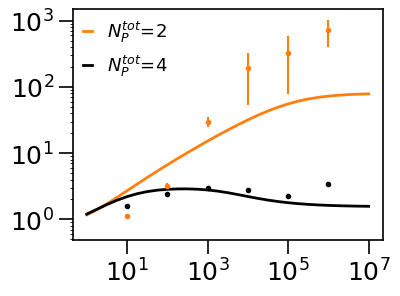

In [7]:
alphas = [1/3, 1]
colors = ['tab:orange', 'black']
plt.figure(figsize=(4,3))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)
    
for i, slcRepeat in enumerate(slcList_repeats):
    plt.errorbar(
        np.array([0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]), 
        slcRepeat[0], slcRepeat[1], 
        ls='', color=colors[i], marker='.', #edgecolors='black', alpha=alphas[1], 
    )
    
for i, ntot in enumerate([2, 4]):
    plt.plot(
        KPPList, ((clustered_onDNA/separated_onDNA))[i], ls='-', 
        label='$N_P^{tot}$=%d'%ntot, lw=2, color=colors[i], #color='tab:orange', alpha=alphas[i], 
        zorder=1,
    )


# plt.title('proteins on DNA', fontsize=13)
plt.legend(loc=[0.01,0.67], fontsize=13, handlelength=0.5, framealpha=0)
plt.loglog()
# plt.ylim([0.,1.01])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

# Selectivity - NERDSS spatial

Raw data availabel while asking. msang2@jh.edu

# Four DNA segments

In [3]:
# results from NERDSS simulations
targetCluster = np.array([1, 2, 3, 4])
figsize = (2.8,4)

import numpy as np
import scipy.stats as stats

def calculate_ttest_pvalue(mean1, se1, mean2, se2, n1=30, n2=30, equal_var=False):
    """
    Calculate t-test p-value from means and standard errors.
    
    Parameters:
    -----------
    mean1, mean2 : float
        Means of the two groups
    se1, se2 : float
        Standard errors of the two groups (can be from bootstrap)
    n1, n2 : int
        Original sample sizes of the two groups
    equal_var : bool, optional
        Whether to assume equal variances (default is False)
    
    Returns:
    --------
    dict
        Contains t-statistic, degrees of freedom, two-tailed p-value, 
        and 95% confidence interval for the difference
    """
    # Calculate mean difference
    mean_diff = mean2 - mean1
    
    # Calculate standard error of the difference
    se_diff = np.sqrt(se1**2 + se2**2)
    
    # Calculate t-statistic
    t_stat = mean_diff / se_diff
    
    # Calculate degrees of freedom
    if equal_var:
        # Pooled variance t-test
        df = n1 + n2 - 2
    else:
        # Welch-Satterthwaite approximation for degrees of freedom (unequal variances)
        df = ((se1**2 + se2**2)**2) / ((se1**4 / (n1-1)) + (se2**4 / (n2-1)))
    
    # Calculate two-tailed p-value
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    
    # Calculate 95% confidence interval
    t_critical = stats.t.ppf(0.975, df)  # 97.5th percentile for 95% CI
    margin = t_critical * se_diff
    ci_lower = mean_diff - margin
    ci_upper = mean_diff + margin
    
    return p_value


In [4]:
class PDB_NERDSS():
    
    def __init__(self, parentDir='', pdbWrite=1e5):
        self._pdir = parentDir
        self._pdbStep = pdbWrite
        self.t = []
        self.x = []
        self.proteinNumbers = []
        self.regions = []
        self.t_longest = []

    
    def read_pdbs(
        self, N_repeat=None, pdbInitial=1e6, pdbMin=0, pdbMax=np.inf, 
        YZcenterList=[], chromRadius=5.5,
        timeStep:float=1e-6
    ):
        '''Read pdbs untill pdbMax
        
        Args:
        
            N_repeat (int, iterable): 
                (int) the number of repeats, will read subfolders named in `range(N_repeat)`
                (iterable of strings) the names of subfolders
            
            pdbMin (int): The min index (number of steps) of pdb read.
            
            pdbMax (int): The max index (number of steps) of pdb read.
            
            YZcenter (float): The center coordinate of Y and Z axes (they are the same) used to calculate r.
            
            timeStep (float): time jump for one step.
            
        Returns:
            None: 
                self.x (list of lists): x coordinates
                self.r (list of lists): r distances
                self.t (list of lists): time points
                self.t_longest (list): the longest time points
        '''
        
        self._pdbMax = pdbMax
        self._YZcenterList = YZcenterList
        self.regions = [[] for i in YZcenterList] + [[]]
        self._tStep = timeStep
        
        if N_repeat is None:
            self._subnames = ['']
        elif isinstance(N_repeat, int):
            self._subnames = [str(i) for i in range(N_repeat)]
        else: # assume it is iterable
            self._subnames = [str(i) for i in N_repeat]
        self._Nrepeats = len(self._subnames)
        
        for subname in self._subnames:
            x = []
            t = []
            NItr = pdbMin # include the initial coordinates
            while NItr < self._pdbMax:
                # in case the simulation does not run through pdbMax*pdbStep
                filename = int(NItr*self._pdbStep+pdbInitial)
                x_itr = []
                try:
                    with open(f'{self._pdir}/{subname}/PDB/{filename}.pdb') as f:
                        for line in f:
                            linelist = line.split()
                            if linelist[2] == 'COM' and linelist[3] == 'P':
                                CRDx = float(linelist[5])
                                CRDy = float(linelist[6])
                                CRDz = float(linelist[7])
                                onDNA = False
                                for iyz, (yCenter, zCenter) in enumerate(self._YZcenterList):
                                    if ((CRDy-yCenter)**2 + (CRDz-zCenter)**2)**0.5 < chromRadius:
                                        self.regions[iyz].append(CRDx)
                                        onDNA = True
                                        break
                                if not onDNA:
                                    self.regions[-1].append(CRDx)
                    t.append(NItr*self._pdbStep*self._tStep)
                    NItr += 1
                except:
                    break

            self.x.append(x)
            self.t.append(t)
        
        self._subnames = [name for i, name in enumerate(self._subnames) if len(self.t[i]) != 0]
        self._Nrepeats = len(self._subnames)
        self.x = [x for i, x in enumerate(self.x) if len(self.t[i]) != 0]
        self.t = [t for t in self.t if len(t)!=0]
                
        
        self.t_longest = self.t[0]
        for t in self.t:
            if len(t) > len(self.t_longest):
                self.t_longest = t
            
    def get_all_x(self, burnInSteps=1):
        '''collect all x coordinates of proteins
        
        Args:
            burnInSteps (int): The min number of pdbs considered. Use this to exclude burn-in steps.
            
        Returns:
            self.x_all (list): The x coordinates of proteins
        '''
        
        self._pdbNumMin = burnInSteps
        self.x_all = []
        
        for nr in range(0, self._Nrepeats):
            self.x_all += [x for x in self.x[nr][self._pdbNumMin:]]
        
        return self.x_all
        

In [5]:
def plot_spatial_partition(PDB, totProtein):

    normalization = [4, 3, 2, 1, 1]

    stepSize = 0.2

    plt.rcParams['font.size']=12
    plt.figure(figsize=(5,4))
    for ir, r in enumerate(PDB.regions):
        hist, bin_edges = np.histogram(r, bins=np.arange(0,201,1))
        plt.stairs(hist/totProtein + stepSize*ir, bin_edges, lw=1.5)
        plt.text(5, stepSize*ir+0.03, '%.0f%% \n(normalized: %.0f%%)'%(100*len(r)/totProtein, 
                                               100*len(r)/totProtein/normalization[ir]))
    plt.xlim([0,200])
    plt.yticks(
        np.array([0,1,2,3,4])*stepSize,
        ['4 Targets', '3 Targets', '2 Targets', '1 Targets', 'In solution'],
    )
    plt.ylim([-stepSize*0.1, 4*stepSize+stepSize*0.7])
    plt.tight_layout()
    plt.show()

## Proteins can form dimers

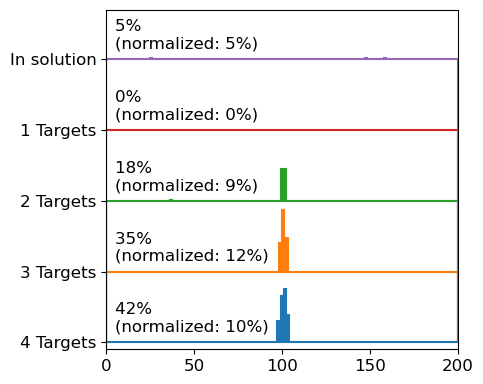

In [24]:
yzCrd = 31.623/2
PDB = PDB_NERDSS(f'./NERDSS/fourDNAs/twoDimers/', pdbWrite=4e7)
PDB.read_pdbs(
    N_repeat=30, timeStep=1e-6, pdbInitial=2e7, pdbMin=0,
    YZcenterList=[[yzCrd,yzCrd], [3*yzCrd,yzCrd], [yzCrd,3*yzCrd], [3*yzCrd,3*yzCrd]]
)
plot_spatial_partition(PDB, np.sum([len(r) for r in PDB.regions]))

In [66]:
N_samples = 30
selectedTraj = [i for i in range(0,0+N_samples)]
yzCrd = 31.623/2
partitionList = []
for i in range(100):
    print(i, end=', ')
    PDB = PDB_NERDSS(f'./NERDSS/fourDNAs/twoDimers/', pdbWrite=9e7)
    PDB.read_pdbs(
        N_repeat=np.random.choice(selectedTraj, size=N_samples, replace=True), 
        timeStep=1e-6, pdbInitial=2e7, pdbMin=0,
        YZcenterList=[[yzCrd,yzCrd], [3*yzCrd,yzCrd], [yzCrd,3*yzCrd], [3*yzCrd,3*yzCrd]]
    )
    totProtein = np.sum([max(len(r),1) for r in PDB.regions])
    partitionList.append([max(len(r),1)/totProtein for r in PDB.regions])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [67]:
DNApartition_2 = (np.mean(partitionList, axis=0)[-2::-1], 
                  np.std(partitionList, axis=0)[-2::-1])
DNApartition_2

(array([0.00320828, 0.19847659, 0.32222788, 0.42536514]),
 array([0.0001675 , 0.03437654, 0.02679387, 0.0279736 ]))

In [68]:
# # total protein number is 428
# DNApartition_2 = ([1/428.        , 0.1932004 , 0.34046152, 0.43666561],
#                  [1/428.        , 0.03428115, 0.02344495, 0.03153427])

In [69]:
for i in range(3):
    mu1 = DNApartition_2[0][i] / targetCluster[i]
    se1 = DNApartition_2[1][i] / targetCluster[i]
    mu2 = DNApartition_2[0][i+1] / targetCluster[i+1]
    se2 = DNApartition_2[1][i+1] / targetCluster[i+1]
    print('Confidence (0.68, 0.95, 0.997)', 1 - calculate_ttest_pvalue(mu1, se1, mu2, se2))

Confidence (0.68, 0.95, 0.997) 0.999995026512642
Confidence (0.68, 0.95, 0.997) 0.32478038588242875
Confidence (0.68, 0.95, 0.997) 0.07466779049700545


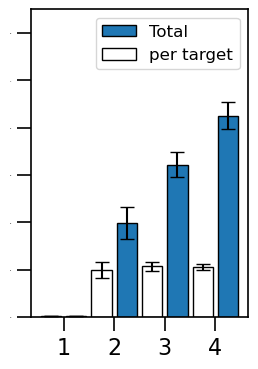

In [70]:
plt.figure(figsize=figsize)
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_2[0], yerr=DNApartition_2[1],
    capsize=5, edgecolor='black', facecolor='tab:blue', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_2[0]/targetCluster, 
    yerr=DNApartition_2[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)

plt.legend(fontsize=12)

plt.xticks(2*targetCluster-0.5, targetCluster, fontsize=16)
plt.yticks(fontsize=0)
plt.ylim([0., 0.65])
plt.show()

## monomer

In [83]:
DNApartition_1 = ([0.01963284, 0.04229797, 0.07063262, 0.0853417],
                 [0.00603037, 0.00844562, 0.00908131, 0.01204614])

In [84]:
for i in range(3):
    mu1 = DNApartition_1[0][i] / targetCluster[i]
    se1 = DNApartition_1[1][i] / targetCluster[i]
    mu2 = DNApartition_1[0][i+1] / targetCluster[i+1]
    se2 = DNApartition_1[1][i+1] / targetCluster[i+1]
    print('Confidence (0.68, 0.95, 0.997)', 1 - calculate_ttest_pvalue(mu1, se1, mu2, se2))

Confidence (0.68, 0.95, 0.997) 0.16236079367983347
Confidence (0.68, 0.95, 0.997) 0.3532995056626267
Confidence (0.68, 0.95, 0.997) 0.39307336090116296


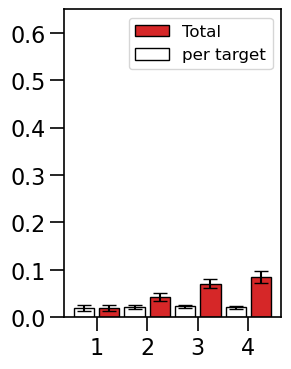

In [14]:
plt.figure(figsize=figsize)
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_1[0], yerr=DNApartition_1[1],
    capsize=5, edgecolor='black', facecolor='tab:red', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_1[0]/targetCluster, 
    yerr=DNApartition_1[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)

plt.legend(fontsize=12)

plt.xticks(2*targetCluster-0.5, targetCluster, fontsize=16)
plt.yticks(fontsize=16)
plt.ylim([0., 0.65])
plt.show()

## Linear tetramer

In [15]:
# DNApartition_4 = ([1/396 , 0.08206282, 0.30460399, 0.54261452],
#                  [1/396, 0.03363388, 0.06487353, 0.08738131])

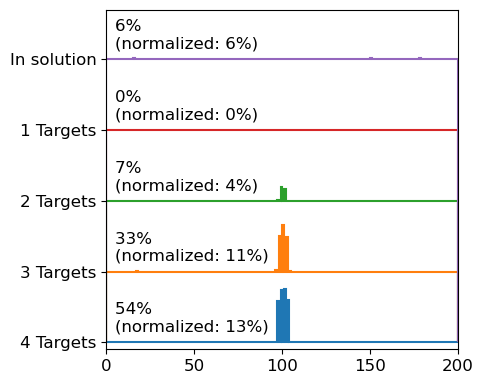

In [30]:
yzCrd = 31.623/2
PDB = PDB_NERDSS(f'./NERDSS/fourDNAs/fourInRow/', pdbWrite=4e7)
PDB.read_pdbs(
    N_repeat=48, timeStep=1e-6, pdbInitial=2e7, pdbMin=0,
    YZcenterList=[[yzCrd,yzCrd], [3*yzCrd,yzCrd], [yzCrd,3*yzCrd], [3*yzCrd,3*yzCrd]]
)
plot_spatial_partition(PDB, np.sum([len(r) for r in PDB.regions]))

In [79]:
N_samples = 30
selectedTraj = [i for i in range(0,0+N_samples)]
yzCrd = 31.623/2
partitionList = []
for i in range(100):
    print(i, end=', ')
    PDB = PDB_NERDSS(f'./NERDSS/fourDNAs/fourInRow/', pdbWrite=8e7)
    PDB.read_pdbs(
        N_repeat=np.random.choice(selectedTraj, size=N_samples, replace=True), 
        timeStep=1e-6, pdbInitial=2e7, pdbMin=0,
        YZcenterList=[[yzCrd,yzCrd], [3*yzCrd,yzCrd], [yzCrd,3*yzCrd], [3*yzCrd,3*yzCrd]]
    )
    totProtein = np.sum([max(len(r),1) for r in PDB.regions])
    partitionList.append([max(len(r),1)/totProtein for r in PDB.regions])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [80]:
DNApartition_4 = (np.mean(partitionList, axis=0)[-2::-1], 
                  np.std(partitionList, axis=0)[-2::-1])
DNApartition_4

(array([0.00285613, 0.06377555, 0.33407644, 0.54918059]),
 array([8.21126968e-05, 2.22301725e-02, 5.12779847e-02, 7.37980743e-02]))

In [81]:
for i in range(3):
    mu1 = DNApartition_4[0][i] / targetCluster[i]
    se1 = DNApartition_4[1][i] / targetCluster[i]
    mu2 = DNApartition_4[0][i+1] / targetCluster[i+1]
    se2 = DNApartition_4[1][i+1] / targetCluster[i+1]
    print('Confidence (0.68, 0.95, 0.997)', 1 - calculate_ttest_pvalue(mu1, se1, mu2, se2))

Confidence (0.68, 0.95, 0.997) 0.9858852067320292
Confidence (0.68, 0.95, 0.997) 0.9997094580543828
Confidence (0.68, 0.95, 0.997) 0.6932697023014103


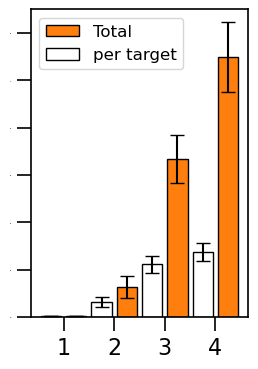

In [82]:
plt.figure(figsize=figsize)
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_4[0], yerr=DNApartition_4[1],
    capsize=5, edgecolor='black', facecolor='tab:orange', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_4[0]/targetCluster, 
    yerr=DNApartition_4[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)

plt.legend(fontsize=12)

plt.xticks(2*targetCluster-0.5, targetCluster, fontsize=16)
plt.yticks(fontsize=0)
plt.ylim([0., 0.65])

plt.show()